# Titration Experiment

In [1]:
#############################
#   Experiment parameters   #
#############################
ROOT_DIR = '/analysis/gh-msun/'
PROJECT_SLUG = '2023_06_26_SRT_deconvolution_MS'
EXPERIMENT = 't_subset_blueprint_5m'
TITRATING_CELLTYPE = 't_reg'
TITRATING_CELLTYPE_ATLAS = 'immune_treg' # cell type name in atlas different
BACKGROUND = 'wholeblood' # background: uniform / wholeblood 
N_REPLICATES = 20 # number of replicates for each mixture
SEED = 888 # need to change for different experiment
TOTAL_READS_TO_SAMPLE = 5000000

# make sure the orders of the two list match
CELLTYPES = ['t_reg',
             't_effector', 
             't_naive',
             'Blueprint-B',
             'Blueprint-NK',
             'Blueprint-Mono',
             'Blueprint-Neutro']
ABRIDGED_NAMES = ['Treg', 'Teff', 'Tnaive', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

# TITRATION_LIST = [0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
#                   0.008, 0.006, 0.004, 0.002, 0.001, 0]


# # proportion of cells in real whole blood (sum to 1)
# WHOLE_BLOOD_ABUNDANCE = {'Blueprint-B':0.06,
#                          'Blueprint-Mono':0.09,
#                          'Blueprint-Neutro':0.57,
#                          't_naive':0.16+0.07,
#                          'Blueprint-NK':0.05}
    

In [2]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import functools
import os
import regex as re
import random
import importlib
import sys

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import IntegerType, LongType, ArrayType, StringType, DoubleType
from pyspark.sql.functions import udf, explode, broadcast, count, lit, length, col
from pyspark.sql import DataFrame
from pyspark.sql.types import StructType

# UPDATE HOME!
os.environ["SPARK_HOME"] = "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark"
# THIS needs to be set-up before running the notebook
os.environ["SPARK_LOCAL_DIRS"] = "/temp"
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

spark_conf = SparkConf()
spark_conf.set("spark.ui.showConsoleProgress", "True")
spark_conf.set("spark.executor.instances", "2")
spark_conf.set("spark.executor.cores", "2")
spark_conf.set("spark.executor.memory", "16g")
spark_conf.set("spark.driver.memory", "64g")
spark_conf.set("spark.driver.maxResultSize", "32g")
spark_conf.set("spark.parquet.filterPushdown", "true")
spark_conf.set("spark.local.dir", "/temp")
spark_conf.getAll()

sc = SparkContext(conf=spark_conf)
sc.setLogLevel("ERROR")
spark = SparkSession(sc)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_context('talk')

/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [3]:
#---Local paths---#
PROJECT_DIR = ROOT_DIR + f'projects/{PROJECT_SLUG}/'

#---Load all custom scripts---#
SCRIPT_DIR = PROJECT_DIR + 'scripts/'
sys.path.append(SCRIPT_DIR)

import create_mixture as cm
import score_matrix as sm
import deconvolution as dcnv
import helper as hlpr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

In [5]:
CELLTYPES = ['t_reg',
             't_effector', 
             't_naive',
             'Blueprint-B',
             'Blueprint-NK',
             'Blueprint-Mono',
             'Blueprint-Neutro']

ABRIDGED_NAMES = ['Treg', 'Teff', 'Tnaive', 'B', 'NK', 'MONO', 'NEUTRO'] # for directory name

TITRATION_LIST = [0.20, 0.15, 0.10, 0.08, 0.06, 0.04, 0.02, 0.01, 
                  0.008, 0.006, 0.004, 0.002, 0.001, 0] # % of total T-cells

# background cell type proportion (T is around 20%)
WHOLE_BLOOD_ABUNDANCE = {'B':0.06,
                         'Mono':0.09,
                         'Neutro':0.57,
                         'NK':0.05}

# background: % of total T-cells (multipy with 0.2)
WHOLE_BLOOD_ABUNDANCE_T = {'t_effector':0.20,
                           't_naive':0.80}

PROPORTIONS = []
treg_titrating_proprotions = [] 
teff_titrating_proprotions = []
tnai_titrating_proprotions = []

for t, alpha in enumerate(TITRATION_LIST):  
    
    # T cell total to be 23 % 
    proportion_treg = 0.23 * alpha  # alpha is the titrating proportion
    proportion_teff = 0.23 * (1-alpha) * WHOLE_BLOOD_ABUNDANCE_T['t_effector'] 
    proportion_tnai = 0.23 * (1-alpha) * WHOLE_BLOOD_ABUNDANCE_T['t_naive'] 
    
    treg_titrating_proprotions.append(proportion_treg)
    teff_titrating_proprotions.append(proportion_teff)
    tnai_titrating_proprotions.append(proportion_tnai)
    
    proportion = [proportion_treg, 
                  proportion_teff, 
                  proportion_tnai,
                  WHOLE_BLOOD_ABUNDANCE['B'],
                  WHOLE_BLOOD_ABUNDANCE['NK'],
                  WHOLE_BLOOD_ABUNDANCE['Mono'],
                  WHOLE_BLOOD_ABUNDANCE['Neutro']]
    
    PROPORTIONS.append(proportion)


In [6]:
teff_titrating_proprotions

[0.036800000000000006,
 0.0391,
 0.041400000000000006,
 0.04232,
 0.04324,
 0.044160000000000005,
 0.04508000000000001,
 0.045540000000000004,
 0.045632000000000006,
 0.04572400000000001,
 0.045816,
 0.045908000000000004,
 0.045954,
 0.046000000000000006]

In [7]:
sum(PROPORTIONS[5][0:3])

0.23000000000000004

## Create mixture

In [8]:
############################
#   Parameters and paths   # 
############################
EXPERIMENT_DIR = PROJECT_DIR + f'output/experiment/{EXPERIMENT}/'
EXPERIMENT_NAME = f'{TITRATING_CELLTYPE}-{BACKGROUND}/'
PARQUET_PATH = PROJECT_DIR + 'output/mixture_source/t_subset_mixture_source/'
EXPERIMENT_CELLTYPE_DIR = EXPERIMENT_DIR + f'{EXPERIMENT_NAME}/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR + 'mixture/'


In [9]:
%%time
# load parquet files for each celltype & count rows
parquet_df, total_reads_per_celltype = cm.load_parquet_dataframe(parquet_path=PARQUET_PATH,
                                                                  cell_types=CELLTYPES,
                                                                  spark=spark,
                                                                  verbose=True)

# mix cell types for each proportion set
cm.mix_celltypes_multiple_proportions(parquet_df=parquet_df,
                                       total_reads_per_celltype=total_reads_per_celltype,
                                    #    n=len(TITRATION_LIST), 
                                       n=N_REPLICATES,
                                       cell_types=CELLTYPES, 
                                       cell_type_abridged_name=ABRIDGED_NAMES, 
                                       total_reads_to_sample=TOTAL_READS_TO_SAMPLE, 
                                       list_of_proportions=PROPORTIONS, 
                                       seed=SEED, 
                                       result_path=RESULT_PATH, 
                                       spark=spark,
                                       verbose=False, 
                                       save=True)

>>> Load parquet files and count rows... <<<
----------> Loading cell type: t_reg
----------> Loading cell type: t_effector
----------> Loading cell type: t_naive
----------> Loading cell type: Blueprint-B
----------> Loading cell type: Blueprint-NK
----------> Loading cell type: Blueprint-Mono
----------> Loading cell type: Blueprint-Neutro
>>> Complete. <<< 

>>> Start mixing... <<<
--> PROPORTION: [0.046000000000000006, 0.036800000000000006, 0.14720000000000003, 0.06, 0.05, 0.09, 0.57]
----------> Creating mixture 0... 
----------> Creating mixture 1... 
----------> Creating mixture 2... 
----------> Creating mixture 3... 
----------> Creating mixture 4... 
----------> Creating mixture 5... 
----------> Creating mixture 6... 
----------> Creating mixture 7... 
----------> Creating mixture 8... 
----------> Creating mixture 9... 
----------> Creating mixture 10... 
----------> Creating mixture 11... 
----------> Creating mixture 12... 
----------> Creating mixture 13... 
----------> 

## Compute score matrix

In [9]:
############################
#   Parameters and paths   # 
############################

FILTER_CG_COUNT = 3
FILTER_CG_COUNT_REGION = 1

REGIONS = 'deconvolution_v2.v23_conv.with_cpg_index'
REGION_BED_COLS = [
    'region_chr', 'region_start', 'region_end', 
    'region_cpg_index_min', 'region_cpg_index_max', 'region_id'
]

# Regions
REGION_PATH = (
    PROJECT_DIR + '/stage/panel_data/{regions}.bed'
).format(regions=REGIONS)

# CpG map; genomic coordinate to CpG index;
CPG_MAP_PATH = PROJECT_DIR + '/stage/cpg_loci/cpg_loci_hg19.combined_annot.tsv.gz'

#--- Where to store results
PATH_TO_MIXTURE_DIR = EXPERIMENT_CELLTYPE_DIR + 'mixture/'
RESULT_PATH = EXPERIMENT_CELLTYPE_DIR


In [10]:
%%time

PAT_COLS = [
    'molecule_id', 'chr', 'number_molecules',
    'cpg_index_min', 'cpg_index_max', 'pat_string', 'region_id', 'region_cpg_index_min', 'region_cpg_index_max'
]

QUANTILES = [0.1, 0.25, 0.75, 0.9]
KMERS = [1, 3, 4]
RATES_LEQ = [0.25]
RATES_GEQ = [0.75]

RETURN_SCHEMA = StructType()\
    .add('region_id', 'string')\
    .add('number_molecules', 'integer')\
    .add('meth_k1', 'integer')\
    .add('unmeth_k1', 'integer')\
    .add('total_k1', 'integer')\
    .add('meth_k3', 'integer')\
    .add('unmeth_k3', 'integer')\
    .add('total_k3', 'integer')\
    .add('meth_k4', 'integer')\
    .add('unmeth_k4', 'integer')\
    .add('total_k4', 'integer')\
    .add('frac_alpha_leq_25pct', 'float')\
    .add('frac_alpha_geq_75pct', 'float')

compute_frag_scores_udf = sm.compute_frag_scores(cpg_number_cutoff=FILTER_CG_COUNT, schema=RETURN_SCHEMA, kmers=KMERS, rates_leq=RATES_LEQ, rates_geq=RATES_GEQ)


# compute methyl score for are parquet files
sm.score_matrix_from_mixture_directory(path_to_mixture_dir = PATH_TO_MIXTURE_DIR, 
                                       result_path = RESULT_PATH, 
                                       pat_cols = PAT_COLS, 
                                       batch_size = 20, 
                                       schema = RETURN_SCHEMA, 
                                       spark=spark,
                                       compute_frag_scores_udf=compute_frag_scores_udf,
                                       save=True, 
                                       verbose=False)

>>> Start computing score matrices <<< 

--> E046TREG_E0368TEFF_E1472TNAIVE_E06B_E05NK_E09MONO_E57NEUTRO
--------> Computing score matrix for mix0_seed512070


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/ec2-user/mambaforge/envs/2023_06_26_SRT_deconvolution_MS/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

## Deconvolution

In [11]:
############################
#   Parameters and paths   # 
############################

FILTER_COV = 20

SCORE_VAR = 'frac_alpha_leq_25pct'

# Reference matrix
ATLAS_PATH = PROJECT_DIR + 'output/reference/tsubset_without_shared/deconv_inhouse_v2.t_subset.only_naive_wo_CM.atlas.tsv.gz'
REGION_PATH = PROJECT_DIR + 'output/reference/tsubset_without_shared/deconv_inhouse_v2.t_subset.only_naive_wo_CM.region_to_ref_celltype.tsv.gz'

# Methylation score matrix
SCORE_DIR = EXPERIMENT_CELLTYPE_DIR + 'methyl_score/'


In [12]:
atlas = pd.read_csv(ATLAS_PATH, sep='\t',index_col=None)
atlas = atlas.set_index('region_id')
atlas.columns.name = 'ref_celltype'
atlas.shape

ref_region_df = pd.read_csv(REGION_PATH, sep='\t')

atlas = atlas.loc[ref_region_df['region_id'], :].copy()
atlas.shape

(292, 11)

In [13]:
%%time

deconvolution_nnls = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR, 
                                                                          score_type=SCORE_VAR, 
                                                                          atlas=atlas, 
                                                                          match=False)

deconvolution_naive = dcnv.compute_deconvolution_from_methyl_score_dir_naive(path_to_methyl_score_dir=SCORE_DIR, 
                                                                             filter_cov=FILTER_COV, 
                                                                             score_var=SCORE_VAR, 
                                                                             ref_region_df=ref_region_df)


CPU times: user 4.57 s, sys: 70.5 ms, total: 4.64 s
Wall time: 4.64 s


In [14]:
deconvolution_nnls[12]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ref_celltype,,,,,,,,,,,,,,,,,,,,
immune_b,0.059247,0.060231,0.059722,0.060791,0.058047,0.060114,0.058625,0.058879,0.061109,0.059719,0.061034,0.058021,0.058704,0.059454,0.058858,0.058595,0.057702,0.059413,0.060055,0.059932
immune_t_naive,0.167898,0.166104,0.167650,0.166494,0.165687,0.170989,0.166524,0.162987,0.168279,0.168542,0.167139,0.163041,0.162042,0.170216,0.166849,0.164101,0.162913,0.163938,0.167529,0.166116
immune_t_effector,0.041487,0.047591,0.043644,0.039880,0.043433,0.043688,0.043893,0.042303,0.042765,0.043926,0.040837,0.044805,0.045402,0.040457,0.042482,0.046799,0.044919,0.039306,0.042512,0.039073
immune_treg,0.000449,0.000271,0.000000,0.001472,0.000218,0.001017,0.000388,0.000571,0.000696,0.000428,0.000121,0.000437,0.000116,0.000187,0.001434,0.000575,0.000763,0.000875,0.000278,0.001123
immune_nk,0.047563,0.047420,0.048764,0.049754,0.048868,0.049034,0.047565,0.048016,0.047453,0.048289,0.047958,0.048223,0.048383,0.048419,0.048306,0.048126,0.048355,0.048014,0.048122,0.047062
immune_mono,0.098012,0.103006,0.092643,0.101748,0.099757,0.095542,0.093793,0.096576,0.101780,0.095244,0.099445,0.099489,0.100053,0.097370,0.098947,0.098317,0.096240,0.099918,0.097561,0.097056
immune_eosi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
immune_neutro,0.558858,0.557337,0.558134,0.556817,0.559387,0.557642,0.557675,0.556421,0.559390,0.559433,0.558449,0.558420,0.561040,0.559036,0.558573,0.558485,0.560331,0.556746,0.556311,0.557597
immune_eryth,0.000719,0.000515,0.000692,0.000495,0.000659,0.000000,0.000646,0.000000,0.000722,0.000000,0.000245,0.000424,0.000641,0.000000,0.000451,0.000000,0.000000,0.000000,0.000835,0.000000


In [15]:
importlib.reload(cm)
importlib.reload(sm)
importlib.reload(dcnv)
importlib.reload(hlpr)

<module 'helper' from '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/scripts/helper.py'>

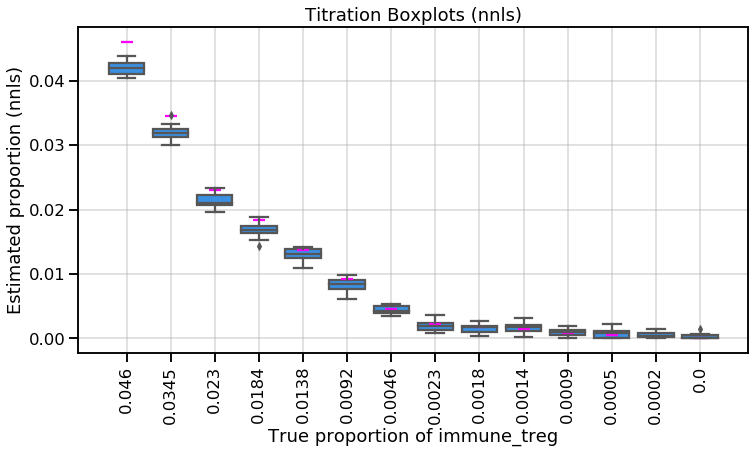

In [16]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=[round(x, 4) for x in treg_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

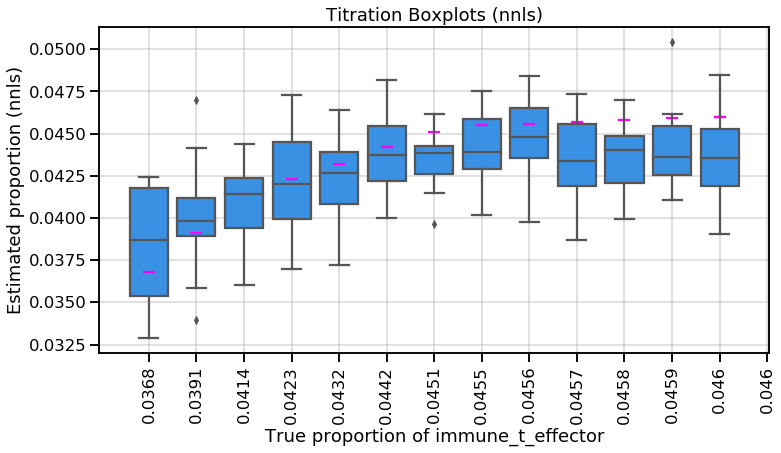

In [17]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_t_effector',
                      true_proportions=[round(x, 4) for x in teff_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

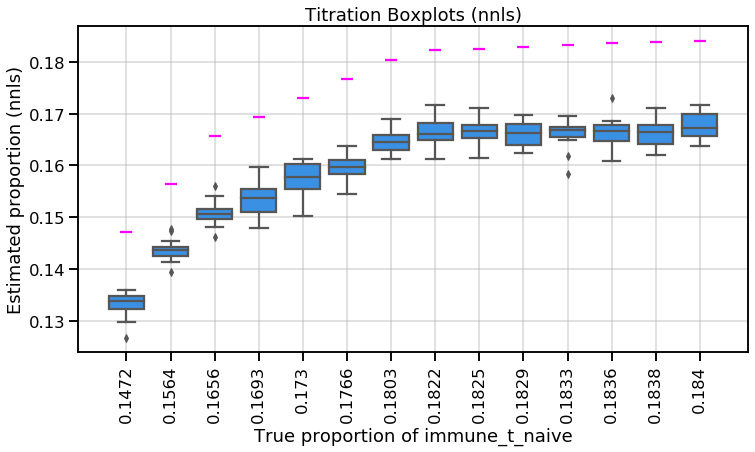

In [18]:
dcnv.boxplot_titration(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type='immune_t_naive',
                      true_proportions=[round(x, 4) for x in tnai_titrating_proprotions],
                      deconvolution_method_name='nnls'
                      )

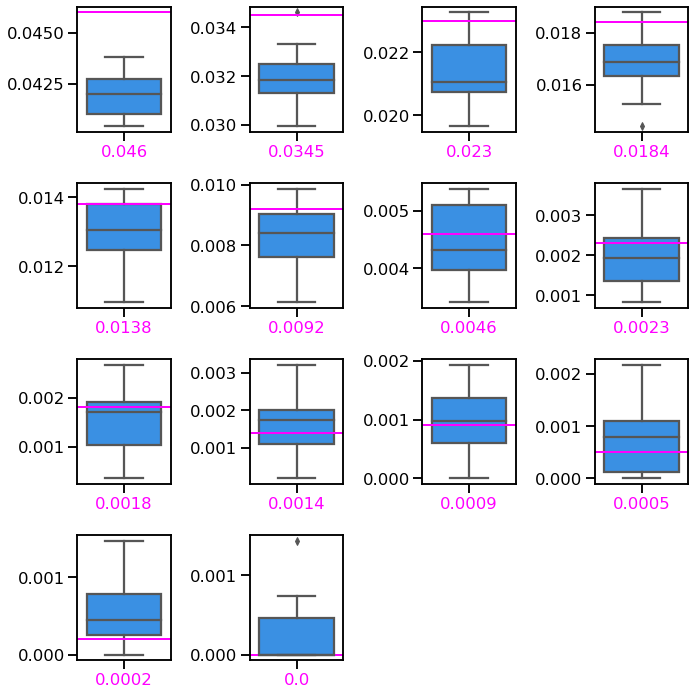

In [19]:
dcnv.boxplot_titration_zoom(list_of_deconvolution_dfs=deconvolution_nnls,
                      cell_type=TITRATING_CELLTYPE_ATLAS,
                      true_proportions=[round(x, 4) for x in treg_titrating_proprotions],
                      deconvolution_method_name='nnls')

In [20]:
# spot check one mixture replicate

In [45]:
%%time

SCORE_DIR_2M = '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_2m/t_reg-wholeblood/methyl_score/'
SCORE_DIR_5M = '/analysis/gh-msun/projects/2023_06_26_SRT_deconvolution_MS/output/experiment/t_subset_blueprint_5m/t_reg-wholeblood/methyl_score/'


# load score data from all cell types
deconvolution_nnls = []

TITRATION_LIST = treg_titrating_proprotions
SCORE_VAR = 'frac_alpha_leq_25pct'
FILTER_COV = 20


deconv_nnls_2M = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR_2M, 
                                                                      score_type=SCORE_VAR, 
                                                                      atlas=atlas, 
                                                                      match=False)

deconv_nnls_5M = dcnv.compute_deconvolution_from_methyl_score_dir_nnls(path_to_methyl_score_dir=SCORE_DIR_5M, 
                                                                      score_type=SCORE_VAR, 
                                                                      atlas=atlas, 
                                                                      match=False)
    
deconvolution_nnls.append(deconv_nnls_2M)
deconvolution_nnls.append(deconv_nnls_5M)

CPU times: user 3.47 s, sys: 40.1 ms, total: 3.51 s
Wall time: 3.51 s


In [46]:
deconv_nnls_2M[1]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ref_celltype,,,,,,,,,,,,,,,,,,,,
immune_b,0.059573,0.058375,0.059165,0.057189,0.058876,0.060365,0.060163,0.061638,0.059980,0.058521,0.057646,0.058397,0.059199,0.062009,0.058519,0.060124,0.057976,0.056336,0.060819,0.059404
immune_t_naive,0.150105,0.153477,0.151351,0.143422,0.156953,0.136080,0.150256,0.148126,0.148238,0.145802,0.153694,0.149330,0.140687,0.142418,0.148311,0.141532,0.140976,0.161008,0.151270,0.132496
immune_t_effector,0.040263,0.032473,0.041061,0.025027,0.033992,0.043227,0.039140,0.038029,0.039034,0.037467,0.042515,0.043925,0.031472,0.036777,0.041239,0.047921,0.041149,0.030264,0.038376,0.041618
immune_treg,0.032332,0.032779,0.030974,0.035651,0.034826,0.031365,0.034126,0.031164,0.034827,0.033736,0.029515,0.028300,0.034216,0.032669,0.029812,0.028900,0.032069,0.029625,0.033126,0.031046
immune_nk,0.047392,0.050647,0.044160,0.048008,0.047167,0.048539,0.046963,0.046740,0.044432,0.046097,0.046952,0.048250,0.048157,0.045514,0.047050,0.045184,0.044139,0.046698,0.047772,0.047958
immune_mono,0.092183,0.098758,0.092989,0.084135,0.098326,0.097963,0.091727,0.101033,0.103333,0.094657,0.095713,0.099909,0.096943,0.104404,0.095263,0.103989,0.100880,0.105276,0.092529,0.112303
immune_eosi,0.000000,0.000000,0.000308,0.000155,0.000000,0.000509,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000596,0.000000,0.000114,0.000000,0.000000,0.000000,0.000000,0.000000
immune_neutro,0.554377,0.559160,0.559908,0.553558,0.558911,0.553946,0.551548,0.552405,0.558184,0.551477,0.553190,0.559660,0.556003,0.559473,0.556987,0.559971,0.558501,0.557876,0.557078,0.561716
immune_eryth,0.001056,0.000000,0.000322,0.000000,0.001655,0.000080,0.000000,0.000000,0.001566,0.000000,0.001289,0.000148,0.000000,0.000000,0.000000,0.000000,0.001274,0.000000,0.001418,0.000313


In [53]:
def lod95_detect_plot(names, titrating_celltypes, titrating_celltype_proportion, deconvolution_preds, detection_threshold, lod=0.95):
    # celltype atlas, deconvolution_predictions list(s), titration list, titrating cell type proportions, decision threshold
    # celltype atlas, deconvolution list(s), titration list, titrating cell type proportions, +/- tolerance
    # support 1 vs all
    # titrating_celltypes = ['immune_t_effector', 'immune_treg']
    # titrating_celltype_proportion = TITRATION_LIST
    # deconvolution_preds = deconvolution_nnls
    # detection_threshold =  0.005
    # lod = 0.95

    data = []
    lod95_value = []

    # <- start loop
    for i, celltype in enumerate(titrating_celltypes):
        
        # celltype_idx = titrating_celltypes.index(celltype)
        preds_for_celltype = deconvolution_preds[i]

        p_detect = []

        for df in preds_for_celltype:
            m, n = df.shape
            phat = df[df.index == celltype]
            phat_boolean = phat > detection_threshold
            p_detected = sum(phat_boolean.values.squeeze()) / n
            p_detect.append(p_detected)

        ###### ----- plotting

        # Replace these with your data
        x_values = titrating_celltype_proportion
        y_values = p_detect 

        data.append((x_values, y_values))

        # Sorting the x_values and y_values in the order of x_values
        sorted_indices = np.argsort(x_values)
        x_values_sorted = np.array(x_values)[sorted_indices]
        y_values_sorted = np.array(y_values)[sorted_indices]

        if x_values_sorted[0] == 0:
            y_values_sorted[0] = 0

        # Interpolating to find the x-value
        y_target = lod
        x_target = np.interp(y_target, y_values_sorted, x_values_sorted)
        lod95_value.append(x_target)


    for i, (x_values, y_values) in enumerate(data):
        name = names[i]
        lod95 = round(lod95_value[i], 3)
        label = f'{name}: {lod95}'
        if x_values[-1] == 0:
            y_values[-1] = 0
        sns.scatterplot(x=x_values, y=y_values, label=label)
        sns.lineplot(x=x_values, y=y_values)

    # Set the limits and spacing of the x and y axes
    plt.xticks(ticks=[i/10 for i in range(11)])
    plt.yticks(ticks=[i/10 for i in range(11)])
    plt.xlim(0, 0.1)
    plt.ylim(0, 1)

    plt.axhline(y=y_target, xmin=0, xmax=x_target+1, color='blue', linestyle='--', linewidth=0.8)

    plt.grid(True, alpha=0.5)
    plt.gca().set_axisbelow(True)

    plt.xlabel('Cell Type Proportion')
    plt.ylabel('% Correctly Identified (x/20)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()
    


In [55]:
def lod95_within_proportion_plot(names, titrating_celltypes, titrating_celltype_proportion, deconvolution_preds, tolerance=0.3, lod=0.95):
    # celltype atlas, deconvolution_predictions list(s), titration list, titrating cell type proportions, decision threshold
    # celltype atlas, deconvolution list(s), titration list, titrating cell type proportions, +/- tolerance
    # support 1 vs all
    # titrating_celltypes = ['immune_t_effector', 'immune_treg']
    # titrating_celltype_proportion = TITRATION_LIST
    # deconvolution_preds = deconvolution_nnls
    # detection_threshold =  0.005
    # lod = 0.95

    data = []
    lod95_value = []

    # <- start loop
    for i, celltype in enumerate(titrating_celltypes):
        
      #  celltype_idx = titrating_celltypes.index(celltype)
        preds_for_celltype = deconvolution_preds[i]

        p_correct = []

        for i in range(0,len(preds_for_celltype)):
            df = preds_for_celltype[i]
            m, n = df.shape
            eps = titrating_celltype_proportion[i] * tolerance
            true_p = titrating_celltype_proportion[i]
            true_p_min = true_p - eps 
            true_p_max = true_p + eps
            phat = df[df.index == celltype]
            phat = phat.values.squeeze()
            phat_boolean = [(true_p_min <= x <= true_p_max) for x in phat]
            p_correct.append(sum(phat_boolean) / n)

        ###### ----- plotting

        # Replace these with your data
        x_values = titrating_celltype_proportion
        y_values = p_correct

        data.append((x_values, y_values))

        # Sorting the x_values and y_values in the order of x_values
        sorted_indices = np.argsort(x_values)
        x_values_sorted = np.array(x_values)[sorted_indices]
        y_values_sorted = np.array(y_values)[sorted_indices]

        if x_values_sorted[0] == 0:
            y_values_sorted[0] = 0

        # Interpolating to find the x-value
        y_target = lod
        x_target = np.interp(y_target, y_values_sorted, x_values_sorted)
        lod95_value.append(x_target)


    for i, (x_values, y_values) in enumerate(data):
        name = names[i]
        lod95 = round(lod95_value[i], 3)
        label = f'{name}: {lod95}'
        if x_values[-1] == 0:
            y_values[-1] = 0
        sns.scatterplot(x=x_values, y=y_values, label=label)
        sns.lineplot(x=x_values, y=y_values)

    # Set the limits and spacing of the x and y axes
    plt.xticks(ticks=[i/10 for i in range(11)])
    plt.yticks(ticks=[i/10 for i in range(11)])
    plt.xlim(0, 0.1)
    plt.ylim(0, 1)

    plt.axhline(y=y_target, xmin=0, xmax=x_target+1, color='blue', linestyle='--', linewidth=0.8)

    plt.grid(True, alpha=0.5)
    plt.gca().set_axisbelow(True)

    plt.xlabel('Cell Type Proportion')
    plt.ylabel('% Correctly Identified (x/20)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()
    


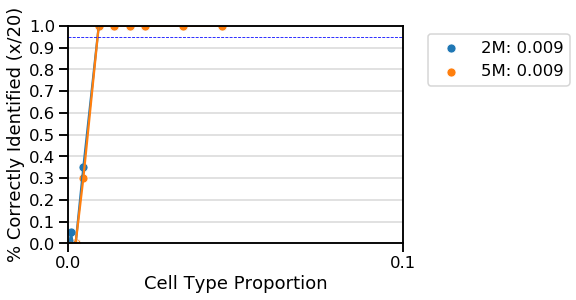

In [56]:
# t effector, t reg order must follow the order in which the predictions were made
lod95_detect_plot(names=['2M', '5M'],
                  titrating_celltypes = ['immune_treg', 'immune_treg'], 
                  titrating_celltype_proportion = TITRATION_LIST, 
                  deconvolution_preds = deconvolution_nnls, 
                  detection_threshold = 0.005, 
                  lod=0.95)

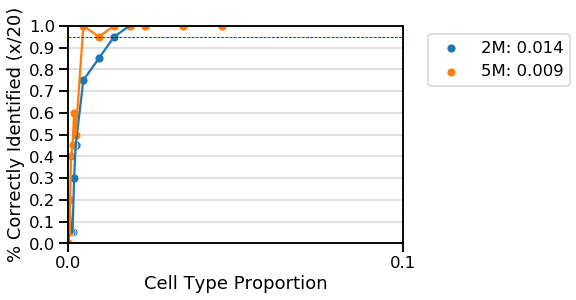

In [57]:
lod95_within_proportion_plot(names=['2M', '5M'],
                            titrating_celltypes = ['immune_treg', 'immune_treg'], 
                              titrating_celltype_proportion = TITRATION_LIST, 
                              deconvolution_preds = deconvolution_nnls, 
                              tolerance = 0.3, 
                              lod=0.95)